# data visualization
In this notebook, SQL queries will be implemented to extract data based on specific filtering criteria. This data will then be read into Pandas dataframes, after which several visuals will be generated (based on the data) using Matplotlib. It's important to note that although these filters could be done by reading the full database into Pandas dataframes and then filtering, keeping the entire data filtering process within Python and Pandas/NumPy, PyMySQL will be used to extract specific data on a per-visual basis instead.

In [1]:
#datbase connector
import pymysql as pms
#local dataframe representations of data
import pandas as pd
#used for quick testing of concepts, but also for math
import numpy as np

## grabbing data
The below function will be utilized again and again to connect to the database, execute a SQL query, extract a result into a Pandas dataframe, and close the database connection. But, first we need to read in the database credentials required for connecting to the MySQL client.

In [2]:
db_user = ""
db_pass = ""
db_name = ""
db_host = ""
db_charset = "utf8"
with open("database_credentials2.txt") as f:
    db_user = f.readline().strip()
    db_pass = f.readline().strip()
    db_name = f.readline().strip()
    db_host = f.readline().strip()

In [3]:
def grab_data(sql):
    """
    1. Open a connection to MySQL using PyMySQL
    2. Grab data based on the specified SQL query and store it in a Pandas dataframe
    3. Close the PyMySQL connection
    4. Return the Pandas dataframe
    """
    try:
        #connect
        con = pms.connect(host=db_host, user=db_user, passwd=db_pass, db=db_name, charset=db_charset)
        #print("Connected: {}".format(con.open))
        
        #execute query and read into dataframe
        #(https://stackoverflow.com/questions/12047193/how-to-convert-sql-query-result-to-pandas-data-structure?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa)
        df = pd.read_sql(sql, con)
    except:
        print("You messed up")
    finally:
        if con:
            #close connection
            con.close()
            #print("Connected: {}".format(con.open))
    
    #return dataframe
    return df

## sample plot
This notebook will utilize [Seaborn](https://seaborn.pydata.org/index.html), a library built on top of [Matplotlib](https://matplotlib.org/), for data visualization. Below we use Seaborn to show the distribution of the Women's division's back squat, clean and jerk, deadlift, and snatch for those who competed in the 2018 CrossFit Open.

In [4]:
#extract data
womens_lifts_df = grab_data(
    """
    SELECT back_squat_lbs, clean_and_jerk_lbs, snatch_lbs, deadlift_lbs FROM athlete WHERE division_id=2 AND (
        back_squat_lbs > 0 AND
        clean_and_jerk_lbs > 0 AND
        snatch_lbs > 0 AND
        deadlift_lbs > 0
    );
    """
)

In [5]:
#import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

### matplotlib styling

In [6]:
#styling settings
#https://matplotlib.org/users/customizing.html
axes_label_size = "medium"
bg_color = "#000000"
font_color = "#ffffff"
sb.set(
    rc = {
        "axes.edgecolor": "green",
        "axes.facecolor": bg_color,
        "axes.labelcolor": font_color,
        #this link for these 2 parameters
        #https://stackoverflow.com/questions/28825594/why-doesnt-the-matplotlib-label-fontsize-work
        "axes.labelsize": 16,
        "axes.titlesize": 16,
        
        "grid.color": font_color,
        "grid.linewidth": .5,
        
        #this link is just for figure.facecolor
        #http://jonathansoma.com/lede/data-studio/matplotlib/changing-the-background-of-a-pandas-matplotlib-graph/
        "figure.facecolor": bg_color,
        "figure.figsize": "8, 6",
        #"figure.titlesize": "large",
        
        "font.family": [u"sans-serif"],
        "font.sans-serif": [
            u"Arial",
            u"sans-serif"
        ],
        
        #"legend.fancybox": True,
        "legend.facecolor": "red",
        "legend.framealpha": .95,
        "legend.fontsize": "medium",
        
        "lines.linewidth": 1.25,
        #"lines.marker": "x",
        #"lines.markersize": 60,
        
        "text.color": font_color,
        
        "xtick.color": font_color,
        #"xtick.labelsize": axes_label_size,
        #"xtick.direction": "out",
        
        "ytick.color": font_color
        #"ytick.labelsize": axes_label_size
    }
)


### plotting women's data

In [7]:
#show sample of data
womens_lifts_df.head(10)

,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs
0,282,207,190,315
1,300,231,200,365
2,315,220,175,355
3,315,220,169,352
4,255,185,160,315
5,250,190,160,300
6,300,225,180,350
7,210,155,130,270
8,275,220,180,385
9,255,208,168,303


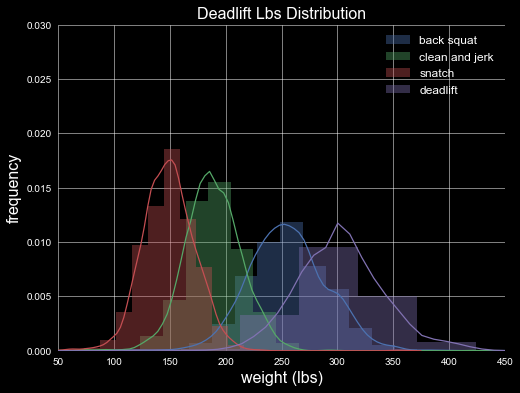

In [8]:
#plot each lift
for c in womens_lifts_df.columns:
    #fit plot
    #fit, ax = plt.subplots(facecolor = "black")
    sb.distplot(np.array(womens_lifts_df[c]), bins=25, label=c[:-4].replace("_", " "))
    #label axes and add to labels for legend
    plt.xlabel(c)
    #grid
    plt.grid(True)
    #title
    plt.title(c.replace("_", " ").title() + " Distribution")
#this is the same for all
plt.xlabel("weight (lbs)")
plt.ylabel("frequency")
#axes bounds
plt.axis([50, 450, 0, 0.03])
#legend (.get_frame().set_alpha() sets the backgroudn on the legend)
leg = plt.legend()
for t in leg.get_texts():
    t.set_color(font_color)
#plt.legend().get_frame().set_alpha(.95)
#show
plt.show()

## scoring athletes basedon performance
Athlete scoring has been written in a separate module called `scorer`. The scorer.py file can be found in this repo, and contains in-depth documentation of how athletes are evaluated. The scoring metric implemented in very similar (but not identical) to that of the CrossFit leaderboard.

One important thing to note is that the leaderboard function was written to reduce repetitive code as much as possible. Therefore, in order to avoid opening connections this notebook within `try` blocks and having to close them and monitor exceptions, the leaderboard expects to open the database connection on it's own.
Given this, the leaderboard function expects a list containing the required database credentials, where the order is the same as that of the `pms.connect()` parameter list in `grab_data()` (host, user, passwd, db, charset).

In [9]:
import importlib
import scorer

In [10]:
open_keys = [
    "leaderboard_{}".format(c) for c in [
        "18_1_reps",
        "18_2_time_secs",
        "18_2a_weight_lbs",
        "18_3_time_secs",
        "18_4_time_secs",
        "18_5_reps"
    ]
]

### boy's 16-17 leaderboard
The below codeblock shows the requirements in order to request a leaderboard. Here, I've gone into the `division` table ahead of time and found that the Boy's (16-17) leaderboard has `id=16`.

In [11]:
#database credentials
creds = [db_host, db_user, db_pass, db_name, db_charset]
#may need to reimport scorer module if changing code inside it between runs
importlib.reload(scorer)
#boys open leaderboard
scorer.leaderboard(16, 0, ["id", "name"] + open_keys, creds).head(5)

,id,name,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps,points
86,671093,DALLIN PEPPER,416,265,301,1073,576,147,40
78,655641,ZACH MAYER,392,298,307,1076,568,152,43
4,382282,DYLAN KADE,402,295,278,1076,572,152,72
369,901799,NICK TUNZI,384,305,322,1097,571,140,91
65,623552,VINCENT RAMIREZ,390,304,290,1057,546,135,91


## the difference between top ranges of athletes
The Open is meant to test general physical preparedness on an accessible level. Athletes send their scores in online, and are ranked according to how well they score based on their fellow in-division competitors. I'm going to plot the worst-performing and highest-performing range for each open leaderboard below. This range will outline the amount of variance between workouts at the highest end of competition. This range will be outlined and shaded.

Within this range, I'll also plot a select few lines, which are representative of select athletes' scores, or average scores for select athlete ranges (average of top 100 for example).

In [12]:
#use men's division for rest of notebook (athlete profiles tend to be more complete)
working_division_id = 1
working_leaderboard = scorer.leaderboard(working_division_id, 0, ["id", "name"] + open_keys, creds)
working_leaderboard.head(5)

,id,name,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps,points
1614,153604,MATHEW FRASER,476,242,380,852,399,198,91
1794,180541,ALEX VIGNEAULT,472,258,382,952,408,179,404
1650,158264,PATRICK VELLNER,476,246,343,851,409,174,539
5078,702092,WILLY GEORGES,460,257,364,892,501,188,541
2977,308712,JEAN-SIMON ROY-LEMAIRE,468,238,346,952,463,178,551


<img src="images/mens_leaderboard_comparison.png" />

The following function is used as a helper to turn data from Pandas dataframes into MySQL parseable queries. Note that again, it'd just be easier to do this in Pandas, but I'm trying to increase my SQL utility.

In [13]:
def grab_top_n_summarizer_data(n, div_id, func_str, dataframe):
    """
    Returns a string of the following form with the ({} filled in accordingly):
        "SELECT {} FROM athlete WHERE division_id={} AND id IN ({});".
    This function requires the athlete ID column as a feature in the specified
    dataframe, in addition to at least 1 field ending in reps, secs, or lbs.
    """
    return grab_data(
        """
            SELECT {} FROM athlete WHERE division_id={} AND id IN ({})
        """
        .format(
            ", ".join(
                    [
                        "{}({}) as '{}top{} {}'".format(
                        #"{}({}) as {}".format(
                            func_str, c, func_str, n,
                            #func_str, c, c
                            c.replace("leaderboard_", "")
                        )
                        for c in dataframe.columns
                           if c.endswith("reps") or c.endswith("secs") or c.endswith("lbs")
                    ]
            ),
            div_id,
            ", ".join([str(x) for x in list(dataframe.head(n)["id"])])
        )
    )

### filtering the data
Let's grab the data corresponding to the top athletes from the database. We'll do this by filtering athletes based on IDs in the men's leaderboard.

In [14]:
ranges = [10, 100, 1000]
funcs = ["MIN", "MAX", "AVG"]
#resulting dataframes are ordered as follows:
#[top10min, top10max, top10avg, top100min, ...]
result = [grab_top_n_summarizer_data(n, working_division_id, f, working_leaderboard)
              for n in ranges for f in funcs]

In [15]:
result[0]

,MINtop10 18_1_reps,MINtop10 18_2_time_secs,MINtop10 18_2a_weight_lbs,MINtop10 18_3_time_secs,MINtop10 18_4_time_secs,MINtop10 18_5_reps
0,441,229,342,846,399,171


### plotting the top 10 ([source](https://matplotlib.org/examples/pylab_examples/fill_between_demo.html))
Below the data is plotted 

In [16]:
working_leaderboard.iloc[1000]["name"]

'JACO VAN DER VYVER'

C:\Users\unknown\AppData\Local\conda\conda\envs\crossfit_open_2018\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


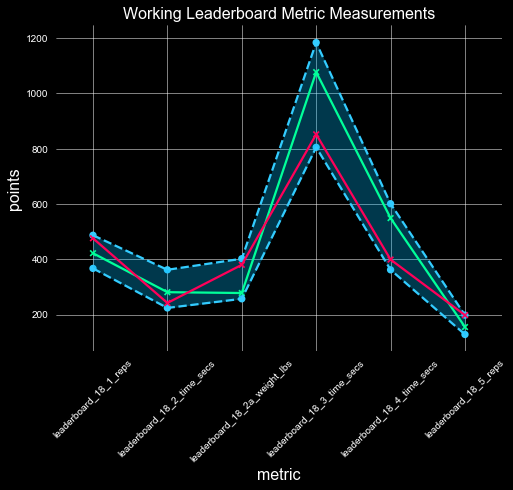

In [17]:
#colors for [lo bounds, lo specific, lo shade, mid bounds, ...]
highlight_colors = ["#ff0059", "#00ff99"]
bounding_colors = ["#33ccff", "#00bbff"]
marker = "x"

#plot specific athletes' data
working_measure_columns = [c for c in working_leaderboard.columns
                               if c.endswith("secs") or c.endswith("reps") or c.endswith("lbs")]
working_athletes = [pd.DataFrame(working_leaderboard.iloc[i][working_measure_columns]).transpose()
                        for i in [0, 1000]]

#plot range of top athletes
for i in [6,7]:
    sb.pointplot(data=result[i], color=bounding_colors[0], linestyles=["--"], markersize=60)

#shading
xlim = int(plt.xlim()[1]) + 1
fill_range = np.array([i for i in range(xlim)])
plt.fill_between(
    fill_range,
    result[6].values[0],
    result[7].values[0],
    color=bounding_colors[1],
    alpha=.3
)

#plot each athlete
for i in range(len(working_athletes)):
    sb.pointplot(
        data=working_athletes[len(working_athletes) - 1 - i],
        color=highlight_colors[len(highlight_colors) - 1 - i],
        markers=marker
        #scale=1
    )
    plt.xlabel(working_leaderboard.iloc[i]["name"])

plt.xlabel("metric")
plt.ylabel("points")
plt.title("Working Leaderboard Metric Measurements")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [18]:
working_athletes[0]

,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps
1614,476,242,380,852,399,198


## the impact of height and weight
One of CrossFit's biggest appeals is that anybody can do it. Whether you're old or young, fat or thin, tall or short, there's usually a scalable alternative to some movement. However, one of the sport's biggest criticisms is that within specific divisions, there's no weight class. Divisions solely split up athletes based on gender and age. Because we have the data, we can see the impact variables like height and weight have on Open scoring.

Below we'll show a heatmap representation of this data. [But first](https://www.youtube.com/watch?v=kdemFfbS5H0&feature=youtu.be&t=36s), let's look at a distribution of the height and weight data.

### grabbing height/weight data from the working table

In [19]:
height_weight_points = working_leaderboard[["id", "name", "points"]].merge(
    grab_data(
        """
            SELECT id, height_in, weight_lbs FROM athlete
                WHERE id IN ({}) AND
                height_in >= 50 AND
                height_in <= 100 AND
                weight_lbs >= 100 AND
                weight_lbs <= 400;
        """
        .format(
            ", ".join([str(x) for x in list(working_leaderboard["id"])])
        )
    )
)

In [20]:
height_weight_points.head(5)

,id,name,points,height_in,weight_lbs
0,153604,MATHEW FRASER,91,67,190
1,180541,ALEX VIGNEAULT,404,71,208
2,158264,PATRICK VELLNER,539,71,195
3,702092,WILLY GEORGES,541,70,190
4,308712,JEAN-SIMON ROY-LEMAIRE,551,69,195


### plotting the distributions

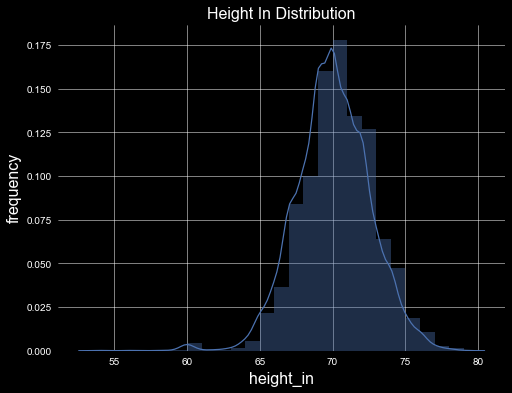

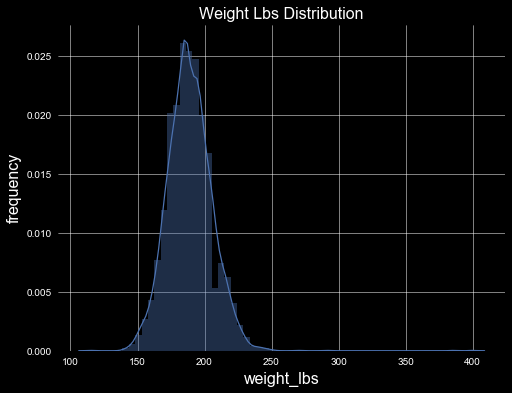

In [30]:
height_weight_cols = ["height_in", "weight_lbs"]
#height_weight_axis_ranges = [[50, 100, 0, 3000], [50, 300, 0, 2000]]
height_weight_bins = [25, 60]
#plot each lift
for i in range(len(height_weight_cols)):
    #fit plot
    sb.distplot(
        np.array(height_weight_points[height_weight_cols[i]]),
        bins=height_weight_bins[i],
        label=c[:-4].replace("_", " "),
        hist_kws = {
            "normed": True
        }
    )
    """plt.hist(
        #height_weight_points[height_weight_cols[i]],
        height_weight_points["height_in"].unique(),
        50,
        alpha=0.5,
        normed=True
    )"""
    #label axes and add to labels for legend
    plt.xlabel(height_weight_cols[i])
    #grid
    plt.grid(True)
    #title
    plt.title(height_weight_cols[i].replace("_", " ").title() + " Distribution")
    #axis display range
    #plt.axis(height_weight_axis_ranges[i])
    #showing/labeling
    plt.xlabel(height_weight_cols[i])
    plt.ylabel("frequency")
    plt.show()

### partitioning the height/weight data into bins

In [36]:
res = pd.cut(height_weight_points[height_weight_cols[0]], height_weight_bins[0], retbins=True)

In [42]:
res

(0       (66.0, 67.0]
 1       (70.0, 71.0]
 2       (70.0, 71.0]
 3       (69.0, 70.0]
 4       (68.0, 69.0]
 5       (68.0, 69.0]
 6       (68.0, 69.0]
 7       (70.0, 71.0]
 8       (72.0, 73.0]
 9       (66.0, 67.0]
 10      (69.0, 70.0]
 11      (68.0, 69.0]
 12      (68.0, 69.0]
 13      (66.0, 67.0]
 14      (68.0, 69.0]
 15      (70.0, 71.0]
 16      (70.0, 71.0]
 17      (66.0, 67.0]
 18      (70.0, 71.0]
 19      (73.0, 74.0]
 20      (69.0, 70.0]
 21      (67.0, 68.0]
 22      (68.0, 69.0]
 23      (69.0, 70.0]
 24      (67.0, 68.0]
 25      (67.0, 68.0]
 26      (69.0, 70.0]
 27      (69.0, 70.0]
 28      (72.0, 73.0]
 29      (68.0, 69.0]
             ...     
 5414    (67.0, 68.0]
 5415    (71.0, 72.0]
 5416    (68.0, 69.0]
 5417    (71.0, 72.0]
 5418    (69.0, 70.0]
 5419    (68.0, 69.0]
 5420    (73.0, 74.0]
 5421    (70.0, 71.0]
 5422    (71.0, 72.0]
 5423    (70.0, 71.0]
 5424    (69.0, 70.0]
 5425    (68.0, 69.0]
 5426    (68.0, 69.0]
 5427    (69.0, 70.0]
 5428    (

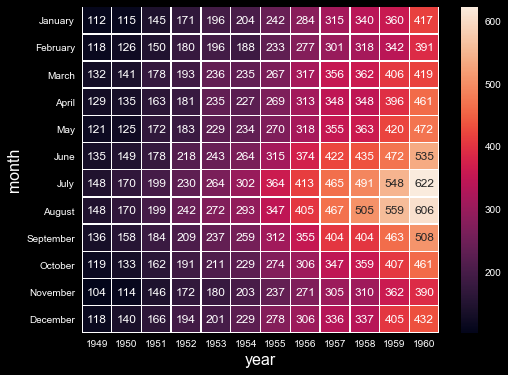

In [22]:
flights_long = sb.load_dataset("flights")
flights = flights_long.pivot("month", "year", "passengers")
sb.heatmap(flights, annot=True, fmt="d", linewidths=.5)
plt.show()

In [108]:
x = pd.DataFrame(
    [[i,j,i * j] for i in range(0,11) for j in range(0, 12)],
    columns=['a', 'b', 'c']
)

In [109]:
x

,a,b,c
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
5,0,5,0
6,0,6,0
7,0,7,0
8,0,8,0
9,0,9,0


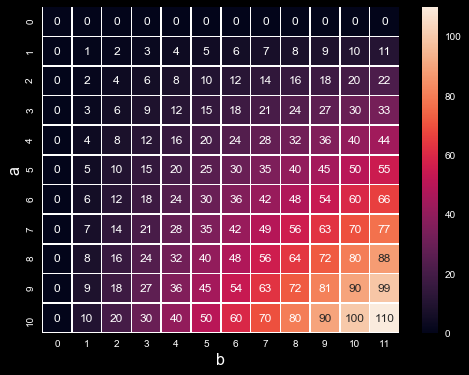

In [112]:
sb.heatmap(x.pivot("a", "b", "c"), annot=True, fmt="d", linewidths=.5)

In [82]:
flights_long.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [67]:
flights_long.keys()

Index(['year', 'month', 'passengers'], dtype='object')

In [98]:
flights_long.keys()

Index(['year', 'month', 'passengers'], dtype='object')

In [84]:
flights_long

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121
5,1949,June,135
6,1949,July,148
7,1949,August,148
8,1949,September,136
9,1949,October,119


In [88]:
flights.index

CategoricalIndex(['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November',
                  'December'],
                 categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', ...], ordered=False, name='month', dtype='category')